In [140]:
import numpy as np

def debug_signal_handler(signal, frame):
    import pdb
    pdb.set_trace()
import signal
signal.signal(signal.SIGINT, debug_signal_handler)

seq_size = 1000

def one_hot_encode_along_channel_axis(sequence):
    #theano dim ordering, uses row axis for one-hot
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#https://www.biostars.org/p/710/
from itertools import groupby
def fasta_iter(fasta_name):
    """
        given a fasta file, yield tuples of (header, sequence)
    """
    fh = open(fasta_name) # file handle
    # ditch the boolean (x[0]) and just keep the header or sequence since they alternate
    fa_iter = (x[1] for x in groupby(fh, lambda line: line[0] == ">"))
    for header in fa_iter:
        header = header.next()[1:].strip() # drop the ">" from the header
        seq = "".join(s.strip() for s in fa_iter.next()) # join all sequence lines to one
        yield header, seq

# take input sequence name and return the onehot encoding
def fasta_to_onehot(input_name):
    fasta_sequences = []

    fasta = fasta_iter(input_name)

    onehot = []
    for header, seq in fasta:   
        fasta_sequences.append(seq)
        onehot_seq = one_hot_encode_along_channel_axis(seq)
        onehot.append(onehot_seq)
        
    return onehot, fasta_sequences

# could be optimized, don't need onehot
'''
def get_snp_scores(score_file, seq_file):
    hyp_scores = np.load(score_file)
    hyp_scores = hyp_scpres[:100]
    off = int((seq_size-1)/2)
    snp_hyp = hyp_scores[:, off]

    #print("snp_hyp shape=", snp_hyp.shape)
    #print("snp_hyp[:5]=\n", snp_hyp[:5])

    onehot = fasta_to_onehot(seq_file)
    snp_onehot = [one_seq[off] for one_seq in onehot]
    #print("onehot done ", len(onehot), snp_onehot[0].shape)
    #print("onehot[:5]=\n", snp_onehot[:5])

    snp_scores = []
    for i in range(len(hyp_scores)):
        snp_score = snp_hyp[i] * snp_onehot[i]
        snp_scores.append(np.sum(snp_score))
    print("snp_scores done ", len(snp_scores))
    print(snp_scores[:5])
    return snp_scores
'''
def get_imp_scores(score_file, seq_file):
    hyp_scores = np.load(score_file)
    onehot, seqs = fasta_to_onehot(seq_file)
    #hyp_scores = hyp_scores[:10]
    #onehot     = onehot[:10]
    #print("onehot done ", len(onehot))
    #print("onehot[:5]=\n", onehot[:5])

    imp_scores = []
    for i in range(len(hyp_scores)):
        contrib_score = hyp_scores[i] * onehot[i]
        #imp_scores.append(np.sum(contrib_score, axis=-1))
        imp_scores.append(contrib_score)

    #print("imp_scores shape=", imp_scores[0].shape, len(imp_scores))
    #print(imp_scores[:2][:5])
    return imp_scores, seqs

def get_snp_hyp_score_diff(score_file, seq_file):
    hyp_scores = np.load(score_file)
    off = int((seq_size)/2)
    snp_hyp = hyp_scores[:, off]

    print("snp_hyp shape=", snp_hyp.shape)
    #print("snp_hyp[:5]=\n", snp_hyp[:5])

    onehot = fasta_to_onehot(seq_file)
    snp_onehot = [one_seq[off] for one_seq in onehot]
    print("onehot done ", len(onehot), snp_onehot[0].shape)
    #print("onehot[:2]=\n", snp_onehot[:2][:5])

    diff_scores = []
    for i in range(len(hyp_scores)):
        snp_score = snp_hyp[i] * snp_onehot[i]
        diff      = snp_hyp[i] - snp_score
        max_diff  = np.max(np.abs(diff), axis=-1)
        #print(diff.shape, max_diff.shape)

        diff_scores.append(max_diff)
    print("diff_scores done ", len(diff_scores))
    #print(diff_scores[:5])
    return diff_scores

def max_sub_array_sum(a, size): 
      
    max_so_far = 0
    max_ending_here = 0
      
    for i in range(0, size): 
        max_ending_here = max_ending_here + a[i] 
        if max_ending_here < 0: 
            max_ending_here = 0
          
        # Do not compare for all elements. Compare only    
        # when  max_ending_here > 0 
        elif (max_so_far < max_ending_here): 
            max_so_far = max_ending_here 
              
    return max_so_far 

def center_window_sum(a, win):
    off = int((seq_size)/2)
    start = off - int(win/2)
    end   = start + win
    score = sum(a[start:end])
    return score

def calc_bis_score(a, size):
    #return max_sub_array_sum(a, size)
    win_sum = center_window_sum(a, size)
    return np.sum(win_sum, axis=-1)

# snp_diffs[i] i= 0,1,2 are the score differences for 3 alleles
# for each allele, it stored differences for each SNP
# for each SNP, it stored differences for 1k bp surrounding the SNP, of shape (1000)
def get_diff_scores(score_prefix, seq_prefix):
    snp_alleles = {}
    snp_diffs   = {}
    snp_orig, _ = get_imp_scores(score_prefix + "0", seq_prefix + "0") # (10k, 1000)
    print("snp_orig shape=", snp_orig[0].shape, len(snp_orig))
    for i in range(3):
        snp_allele, _  = get_imp_scores(score_prefix + str(i+1), seq_prefix + str(i+1)) # (10k, 1000)
        snp_diff    = [s - o for o,s in zip(snp_orig, snp_allele)] # (10k, 1000)
        snp_alleles[i] = snp_allele
        snp_diffs  [i] = snp_diff
        print("snp_diff " + str(i+1) + " shape=", snp_diff[0].shape) #, "\n" , snp_diff[:2][:5])
    return snp_diffs
        
def get_bis_scores(snp_diffs):
    bis_scores  = {}
    for i in range(3):
        bis_scores[i] = [calc_bis_score(diff, 1) for diff in snp_diffs[i]]
    # elementwise max among 3 lists
    max_bis_score = np.maximum.reduce([bis_scores[0], bis_scores[1], bis_scores[2]])
    print("len of max_bis_score=", len(max_bis_score), "\n", max_bis_score[:5])
    return max_bis_score


from numpy import genfromtxt
import math

def get_snp_pvals(fname):
    snp_pvals = []
    with open(fname) as in_fh:
        header = next(in_fh)
        line_num = 0
        for line in in_fh:
            fields = line.split('\t')
            snp_chrom = fields[0]
            snp_pos   = int(fields[1])
            pval  = float(fields[9])
            snp_pvals.append(-math.log(pval, 10))
            line_num += 1
    return snp_pvals

-----
scores/interpret.fa0
(3, 1000, 4)
[[-0.01162638  0.04715768 -0.0307419  -0.04604579]
 [-0.01808871  0.02667512  0.10623307 -0.03159961]
 [-0.09169117  0.03286098  0.04629155 -0.11167513]
 [ 0.0677304  -0.01777698  0.13250516  0.12589005]
 [-0.06616085  0.01574943 -0.01188382 -0.00399282]
 [-0.01924318  0.00356644 -0.058839    0.02176349]
 [ 0.08666077  0.05500435 -0.01942567 -0.04190074]
 [ 0.03267826  0.07431725  0.00670941  0.02390764]
 [ 0.00943129  0.0676337  -0.01355417 -0.00538844]
 [ 0.00996912  0.00691026 -0.01643113  0.00012863]]
-----
SNP chr5:1295162 T->G
('CAGCGCTGCC[T]GAAACTCGC', 'importance score for original sequence')


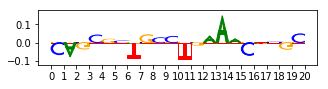

('CAGCGCTGCC[G]GAAACTCGC', 'importance score for mutated sequence ')


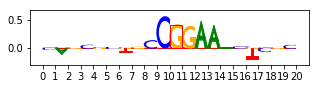

Mutation Impact Score 


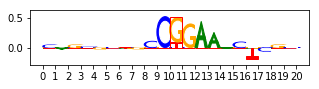

SNP chr5:1295228 G->A
('CAGCGCTGCC[G]GAAACTCGC', 'importance score for original sequence')


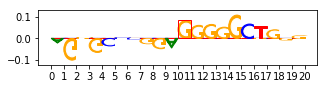

('CAGCGCTGCC[A]GAAACTCGC', 'importance score for mutated sequence ')


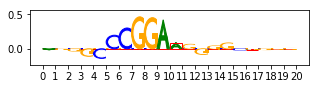

Mutation Impact Score 


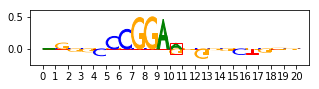

SNP chr5:1295250 G->A
('CAGCGCTGCC[G]GAAACTCGC', 'importance score for original sequence')


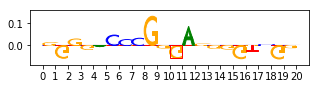

('CAGCGCTGCC[A]GAAACTCGC', 'importance score for mutated sequence ')


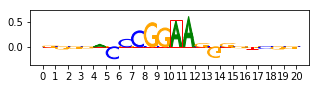

Mutation Impact Score 


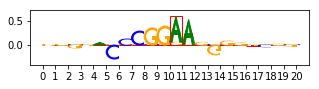

('len of max_bis_score=', 3, '\n', array([ 0.50582868,  0.00753037,  0.59503555], dtype=float32))


In [148]:
from modisco.visualization import viz_sequence
np.set_printoptions(suppress=True)

score_prefix = "scores/hyp_scores_task_0.npy"
seq_prefix   = "scores/interpret.fa"
snp_alleles = {}
snp_diffs   = {}
snp_orig, seqs = get_imp_scores(score_prefix + "0", seq_prefix + "0") # (10k, 1000)
score_file = score_prefix + "0"
seq_file   = seq_prefix + "0"

hyp_scores = np.load(score_file)
onehot, _  = fasta_to_onehot(seq_file)

print("-----")
print(seq_file)
print(hyp_scores.shape)
print(hyp_scores[2][495:505])
print("-----")
#hyp_scores = hyp_scores[:10]
#onehot     = onehot[:10]
#print("onehot done ", len(onehot))
#print("onehot[:5]=\n", onehot[:5])

imp_scores = []
for i in range(len(hyp_scores)):
    contrib_score = hyp_scores[i] * onehot[i]
    imp_scores.append(np.sum(contrib_score, axis=-1))

'''
highlight={'r':[(10,11)]}
for start_pos, end_pos in highlight['r']:
    print(highlight['r'])
    print(start_pos, end_pos)
'''

allele_idx = [2,0,0] # T->G(2), G->A(0), G->A(0)

snp_desc   = ["SNP chr5:1295162 T->G", "SNP chr5:1295228 G->A", "SNP chr5:1295250 G->A"]

def seqs_str(seqs):
    return seqs[0][490:500] + '[' + seqs[0][500:501] + ']' + seqs[0][501:510]

#print("snp_orig shape=", snp_orig[0].shape, len(snp_orig))
for snp in range(3):
    #print(fasta_sequences[snp][495:505])
    #print(snp_orig[snp][495:505])
    print(snp_desc[snp])
    print(seqs_str(seqs), "importance score for original sequence")

    viz_sequence.plot_weights(snp_orig[snp][490:510], figsize=(5,1), highlight={'r':[(10,11)]})

    bis_scores  = {}


    for i in range(3): # each i is an allele
        snp_allele, seqs  = get_imp_scores(score_prefix + str(i+1), seq_prefix + str(i+1)) # (10k, 1000)

        snp_diff    = [s - o for o,s in zip(snp_orig, snp_allele)] # (10k, 1000)
        #snp_alleles[i] = snp_allele
        snp_diffs  [i] = snp_diff

        if i == allele_idx[snp]:
            print(seqs_str(seqs), "importance score for mutated sequence ")
            #print(snp_allele[snp][495:505])
            viz_sequence.plot_weights(snp_allele[snp][490:510], figsize=(5,1), highlight={'r':[(10,11)]})
            #print("snp_diff " + str(i+1) + " shape=", snp_diff[0].shape)
            print("Mutation Impact Score ")
            #print(snp_diff[snp][495:505])
            viz_sequence.plot_weights(snp_diff[snp][490:510], figsize=(5,1), highlight={'r':[(10,11)]})

        bis_scores[i] = [calc_bis_score(diff, 1) for diff in snp_diffs[i]]
        # elementwise max among 3 lists
        #print("bis_scores\n", bis_scores[i])

max_bis_score = np.maximum.reduce([bis_scores[0], bis_scores[1], bis_scores[2]])
print("len of max_bis_score=", len(max_bis_score), "\n", max_bis_score[:5])



In [142]:
#diff_scores = get_snp_hyp_score_diff("scores/hyp_scores_task_0.npy")
snp_diffs  = get_diff_scores("scores/hyp_scores_task_0.npy", "scores/interpret.fa")
print(snp_diff[snp][495:505])

bis_scores = get_bis_scores(snp_diffs)
print(bis_scores)

('snp_orig shape=', (1000, 4), 3)
('snp_diff 1 shape=', (1000, 4))
('snp_diff 2 shape=', (1000, 4))
('snp_diff 3 shape=', (1000, 4))
[[ 0.         -0.09585033  0.          0.        ]
 [ 0.          0.03162419  0.          0.        ]
 [ 0.          0.07554024 -0.          0.        ]
 [-0.          0.         -0.11468191  0.        ]
 [ 0.          0.         -0.01623045  0.        ]
 [ 0.          0.          0.058839    0.00744578]
 [ 0.04997885  0.          0.          0.        ]
 [-0.         -0.          0.06165005 -0.        ]
 [ 0.          0.         -0.02561828  0.        ]
 [ 0.         -0.         -0.0102485  -0.        ]]
('len of max_bis_score=', 3, '\n', array([ 0.50582868,  0.00753037,  0.59503555], dtype=float32))
[ 0.50582868  0.00753037  0.59503555]
